<a href="https://colab.research.google.com/github/Heloput/machinelearning/blob/main/Horse_or_Human_NoValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2024-12-25 12:37:14--  https://storage.googleapis.com/learning-datasets/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.207, 173.194.215.207, 173.194.216.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   110MB/s    in 1.3s    

2024-12-25 12:37:16 (110 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



Следующий код Python будет использовать библиотеку **os**, предоставляя вам доступ к файловой системе и библиотеке zipfile, позволяющей распаковать данные.

In [2]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

Содержимое .zip извлекается в базовый каталог `/tmp/horse-or-human`, каждый из которых, в свою очередь, содержит подкаталоги horse и people.

Вкратце: тренировочный набор - это данные, которые используются, чтобы сказать модели нейронной сети, что «Вот как выглядит лошадь», «Вот как выглядит человек» и т. д.

В этом примере нужно обратить внимание на одну вещь: мы не обозначаем изображения явно как лошади или люди. Если вы помните с примером почерка ранее, мы пометили «это 1», «это 7» и т. д. Позже вы увидите, что используется ImageGenerator - и он сделан чтобы читать изображения из подкаталогов и автоматически помечать их именем этого подкаталога. Так, например, у вас будет каталог 'training', содержащий каталог 'horse' и каталог 'people'. ImageGenerator помечает изображения так как вам нужно, сокращая этап кодирования.

Давайте определим каждый из этих каталогов:

In [3]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

Теперь давайте посмотрим, как выглядят имена файлов в каталогах обучения `horses` и `humans`:

In [4]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse21-8.png', 'horse35-4.png', 'horse32-7.png', 'horse22-4.png', 'horse30-9.png', 'horse17-7.png', 'horse25-8.png', 'horse12-3.png', 'horse13-0.png', 'horse37-4.png']
['human13-00.png', 'human03-28.png', 'human09-06.png', 'human05-23.png', 'human08-16.png', 'human17-25.png', 'human12-21.png', 'human09-12.png', 'human06-07.png', 'human15-00.png']


Давайте выясним общее количество изображений лошади и человека в каталогах:

In [5]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


Теперь давайте взглянем на несколько картинок, чтобы лучше понять, как они выглядят. Сначала настройте параметры matplot:

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Теперь покажите пакет из 8 изображений лошадей и 8 человек. Каждый раз, запуская эту ячейку вы увидите новый пакет:

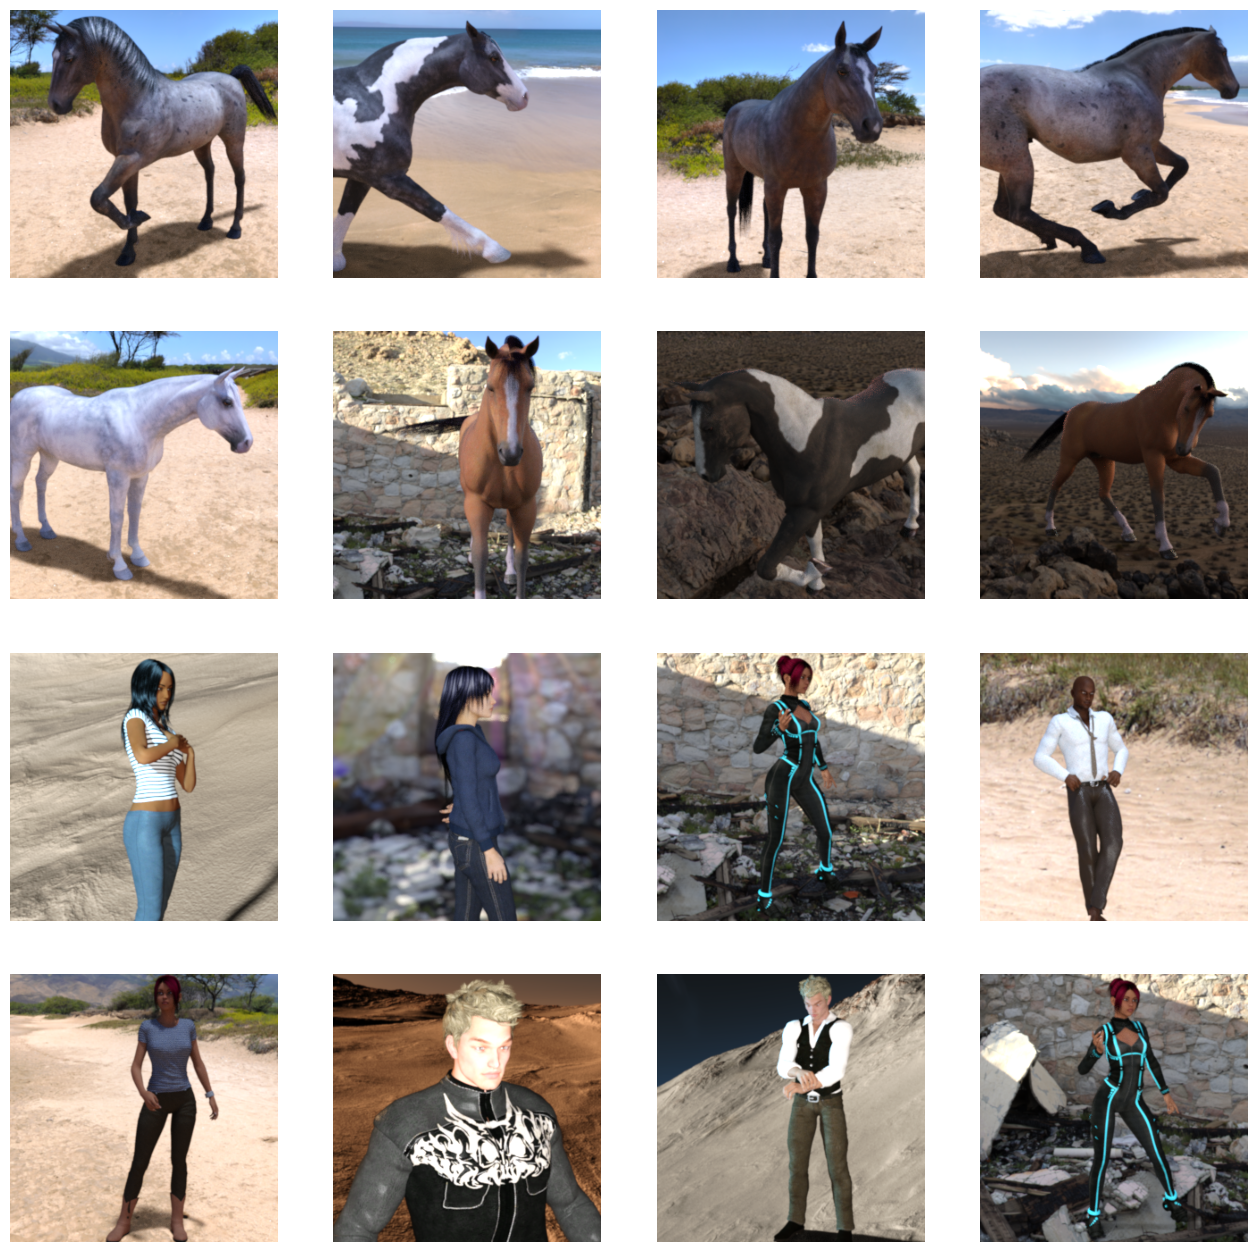

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Создание маленькой модели с нуля

Но прежде чем мы продолжим, давайте начнем определять модель:

Шаг 1: импорт tensorflow.

In [8]:
import tensorflow as tf

Затем мы добавляем сверточные слои, как в предыдущем примере, и выравниваем конечный результат для подачи в полносвязные слои.

Наконец мы добавляем плотно связанные слои.

Обратите внимание, что, поскольку мы сталкиваемся с проблемой классификации двух классов, то есть *проблемой двоичной классификации*, мы завершим нашу сеть с помощью [функции активации *sigmoid*](https://wikipedia.org/wiki/Sigmoid_function), так что выход нашей сети  - это один скаляр от 0 до 1, показывающий вероятность того, что текущее изображение относится к классу 1 (в противоположность классу 0).

In [20]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


метод model.summary()  печатает сводку нашей нейронной сети

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 298, 298, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 147, 147, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 33, 33, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

Столбец «output shape» показывает, как изменяется размер вашей карты признаков в каждом следующем слое. Слои свертки немного уменьшают размер карт признаков из-за потерь на краях изображений, и каждый слой пуллинга сокращает размерности вдвое.

 Далее мы настроим спецификации для обучения модели. Мы будем тренировать нашу модель с функцией потерь `binary_crossentropy`, потому что это проблема бинарной классификации, а наша последняя активация - сигмоида. (Для получения дополнительной информации о показателях потерь см. [Ускоренный курс машинного обучения](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) Мы будем использовать Оптимизатор `rmsprop` со скоростью обучения 0,001. Во время обучения мы хотим отслеживать точность классификации.
**ПРИМЕЧАНИЕ**: в этом случае использование [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) предпочтительнее [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), потому что RMSprop  Автоматически настраивает скорость обучения для нас. (другие оптимизаторы, такие как [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) и [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), также автоматически адаптируют скорость обучения во время обучения, и будут работать здесь так же хорошо.)

In [13]:
#from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['acc'])

# Предварительная обработка данных

Давайте настроим генераторы данных, которые будут читать изображения в наших исходных папках, преобразовывать их в тензоры `float32` и подавать их (с их метками) в нашу сеть. У нас будет один генератор для обучающих изображений и один для проверочных изображений. Наши генераторы будут выдавать партии изображений размером 300x300 и их метки (двоичные).

Как вы, возможно, уже знаете, данные, поступающие в нейронные сети, обычно должны каким-то образом нормализоваться, чтобы сделать их более пригодными для обработки сетью. В нашем случае мы будем предварительно обрабатывать наши изображения путем нормализации значений пикселей, чтобы они находились в диапазоне `[0, 1]` (изначально все значения находятся в дипазоне `[0, 255]`).

В Keras это можно сделать с помощью класса `keras.preprocessing.image.ImageDataGenerator` с использованием параметра `rescale`. Этот класс `ImageDataGenerator` позволяет создавать экземпляры генераторов пакетов дополненных изображений (и их меток) с помощью `.flow(data, label` или `.flow_from_directory(dirname)`. Затем эти генераторы можно использовать с методами модели Keras, которые принимают генераторы данных в качестве входных данных: `fit_generator`, `evaluate_generator`, and `predict_generator`.



In [14]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 1027 images belonging to 2 classes.


### Тренировка
Давайте потренируемся 15 эпох - это может занять несколько минут.
Обратите внимание на значения в эпохе.

`Loss` и `accuracy` являются отличными показателями прогресса обучения. Делается предположение о классификации обучающих данных, а затем оно сравнивается с известной меткой, вычисляя результат. Точность - это доля  правильных догадок.

In [16]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=15,
      verbose=1)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 426ms/step - acc: 0.5457 - loss: 0.6898
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5156 - loss: 0.6784  
Epoch 3/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - acc: 0.5939 - loss: 0.6624
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.9062 - loss: 0.4531  
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 313ms/step - acc: 0.7388 - loss: 0.6185
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 1.0000 - loss: 0.3804
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 352ms/step - acc: 0.6910 - loss: 0.5886
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7188 - loss: 0.4838  
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - acc: 0.9201 - loss: 0.2510
Epoch 10/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 1.0000 - loss: 0.0225
Epoch 11/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - acc: 0.9380 - loss: 0.1978
Epoch 12/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 1.0000 - loss: 0.1083
Epoch 13/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 305ms/step - acc: 0.9515 - loss: 0.1335
Epoch 14/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6667 - loss: 0.4245 
Epoch 15/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 272ms/step - acc: 0.

### Запуск модели

Давайте теперь посмотрим как на самом деле работает предсказание с использованием модели. Этот код позволит вам выбрать 1 или более файлов из вашей файловой системы, затем он загрузит их и проведет их через модель, указав, является ли объект лошадью или человеком.


In [22]:
import numpy as np
from google.colab import files
#from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = tf.keras.preprocessing.image.load_img(path, target_size=(300, 300))
  x = tf.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")


Saving filmz.ru_f_179933.jpg to filmz.ru_f_179933.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
[1.]
filmz.ru_f_179933.jpg is a human


### Визуализация промежуточных представлений

Чтобы понять, какие признаки выявил наш коннет, нужно сделать одну интересную вещь - визуализировать, как преобразуется вход при его прохождении через коннет.

Давайте выберем случайное изображение из обучающего набора, а затем сгенерируем фигуру, где каждая строка является выходом слоя, а каждое изображение в строке является специальным фильтром в этой выходной карте объектов. Перезапустите эту ячейку, чтобы получить промежуточные представления для различных обучающих изображений.

In [21]:
import numpy as np
import random
#from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = tf.keras.preprocessing.imageюload_img(img_path, target_size=(300, 300))  # this is a PIL image
x = tf.keras.preprocessing.image.img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

ValueError: The layer sequential_1 has never been called and thus has no defined input.

Как вы можете видеть, мы переходим от необработанных пикселей изображений к все более абстрактным и компактным представлениям. Представления начинают выделять то, на что обращает внимание сеть, и они показывают, что все меньше и меньше признаков  «активируются»; Большинство из них обнуляются. Это называется 'sparsity'. Разреженность представлений является ключевой особенностью глубокого обучения.

Эти представления несут все меньше информации об исходных пикселях изображения, но все более уточняют информацию о классе изображения. Вы можете представлять себе convNet (или глубокую сеть в целом) как о канале дистилляции информации.

## Очистить

Перед каждым выполнением упражнения запустите эту ячейку, чтобы завершить работу ядра и освободить ресурсы памяти:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)